In [6]:
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
import os

from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, RepeatVector, LSTM, Dense, Lambda, TimeDistributed
from tensorflow.keras import losses, metrics, activations
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import seaborn as sns

In [25]:
split = pickle.load(open('./final_data_ST_120_2019.pkl', 'rb'))['ST4000DM000']
file_list = os.listdir('./ST4000DM000')
train_list = split['train']
val_list = split['val']
test_list = split['test']
col = ['smart_7_raw', 'smart_9_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'until_fail_days']
timestep_list = [5, 10, 20, 30]

In [64]:
scaler_path = './std_scaler_all.pkl'
scaler_zip = {f'{db_type}':[] for db_type in [30, 60, 120]}
db_zip = {f'{db_type}':[] for db_type in [30, 60, 120]}
if not os.path.isfile(scaler_path):
    for file_name in train_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}.pkl', 'rb'))
        for db_type in [30, 60, 120]:
            temp = db[db['until_fail_days']>db_type][col[:-1]]
            db_zip[f'{db_type}'].extend(temp.values)
        
    for db_type in [30, 60, 120]:
        scaler = StandardScaler()
        scaler.fit(db_zip[f'{db_type}'])
        scaler_zip[f'{db_type}'] = scaler
    pickle.dump(scaler_zip, open(scaler_path, 'wb'))
else:
    scaler_zip = pickle.load(open(scaler_path, 'rb'))

In [45]:
scaler_path = './std_scaler.pkl'
scaler_zip = {f'{file_name[:-4]}':{} for file_name in file_list}
if not os.path.isfile(scaler_path):
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        for db_type in [30, 60, 120]:
            temp = db[db['until_fail_days']>db_type][col[:-1]]
            if len(temp) != 0:
                scaler = StandardScaler()
                scaler.fit(temp)
                scaler_zip[f'{file_name[:-4]}'][f'{db_type}'] = scaler
    
    pickle.dump(scaler_zip, open(scaler_path, 'wb'))
else:
    scaler_zip = pickle.load(open(scaler_path, 'rb'))

In [50]:
# prediction_model = tf.keras.models.load_model('./model.h5')
# diagnostic_model = tf.keras.models.load_model('./Model/db_type_60_time_step_20_batch_128_node_128/db_type_60_time_step_20_batch_128_node_128.h5')
diagnostic_model = tf.keras.models.load_model('./Model_STD/db_type_120_time_step_20_batch_128_node_32/db_type_120_time_step_20_batch_128_node_32.h5')

In [5]:
def flatten(X):
    '''
    Flatten a 3D array.

    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.

    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
    return (flattened_X)

In [56]:
np.shape([test_db.iloc[i]])

(1, 5)

In [61]:
db

deque([array([[-0.57873527,  2.6363405 ,  2.635669  ,  1.89061863,  3.64894241]]),
       array([[-0.57596223,  2.74107999,  2.74039757,  1.91971248,  3.76558965]]),
       array([[-0.5728246 ,  2.84581948,  2.84512614,  1.95806416,  3.89339121]]),
       array([[-0.56566463,  2.94619482,  2.94549102,  1.9933505 ,  4.04120006]]),
       array([[-0.56251914,  3.0509343 ,  3.05021959,  2.03024074,  4.13937439]]),
       array([[-0.55984064,  3.15567379,  3.15494815,  2.09246884,  4.2547576 ]]),
       array([[-0.5542776 ,  3.26041328,  3.25967672,  2.12389236,  4.36335327]]),
       array([[-0.55071674,  3.36078862,  3.36440529,  2.16346387,  4.47468399]]),
       array([[-0.54827551,  3.46552811,  3.46477017,  2.21833342,  4.60616198]]),
       array([[-0.54596857,  3.5702676 ,  3.56949874,  2.27495712,  4.72504154]]),
       array([[-0.54357405,  3.67500708,  3.67422731,  2.30242375,  4.85391022]]),
       array([[-0.53777054,  3.77974657,  3.77895588,  2.3452266 ,  5.02022667]]),
    

In [73]:
aa = []
for i in test_list:
    dd = pickle.load(open(f'./ST4000DM000/{i}.pkl', 'rb'))[col[:-1]]
    aa.extend(dd.values)
    
scaler = StandardScaler()
scaler.fit(aa)

StandardScaler()

In [86]:
scaler.transform([test_db.iloc[i].values])[0]

array([-1.14174078, -0.36106595, -0.35854754,  0.37192489, -0.05545252])

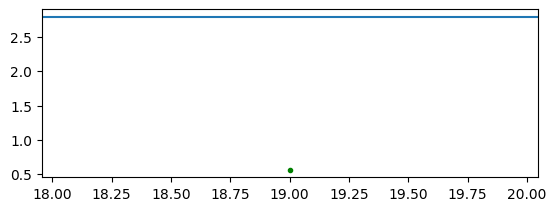

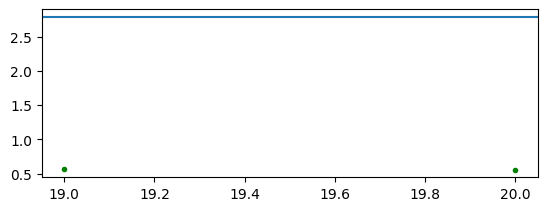

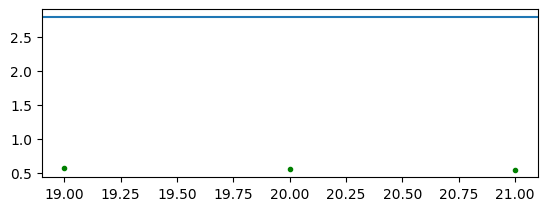

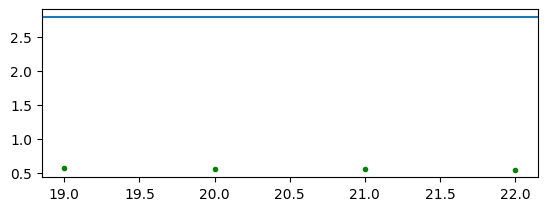

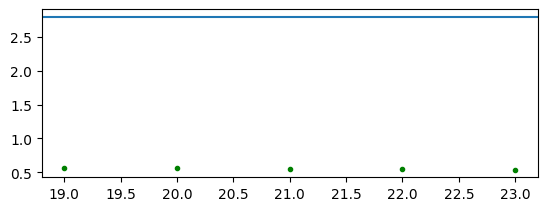

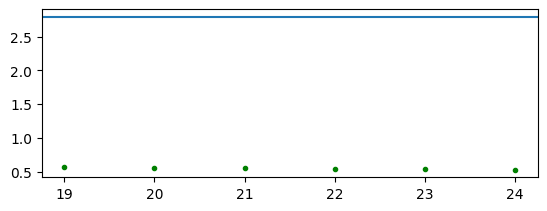

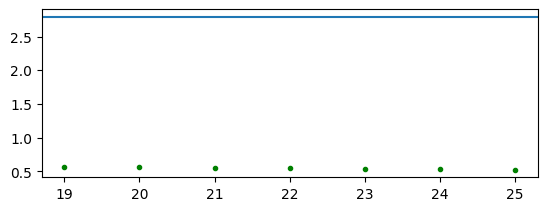

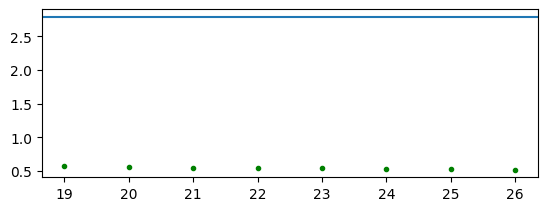

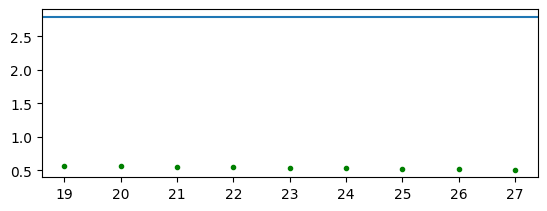

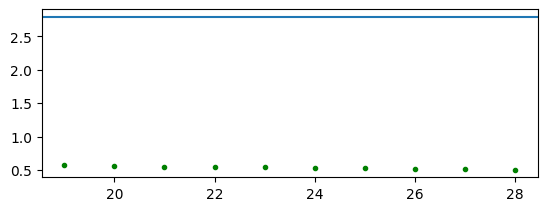

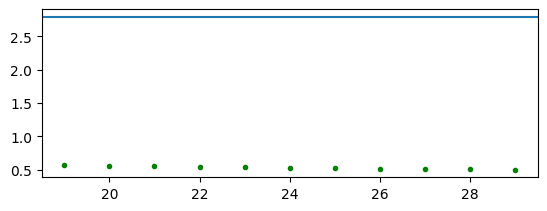

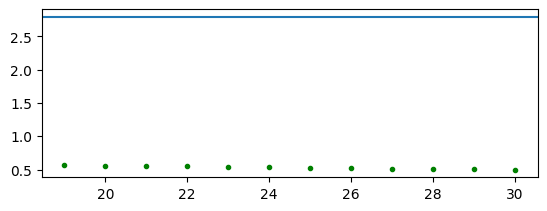

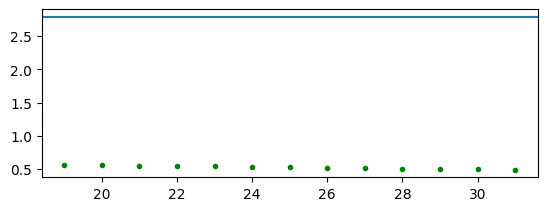

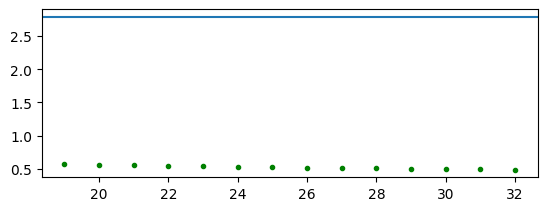

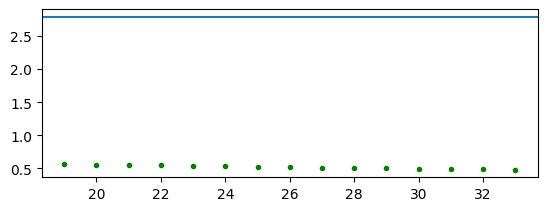

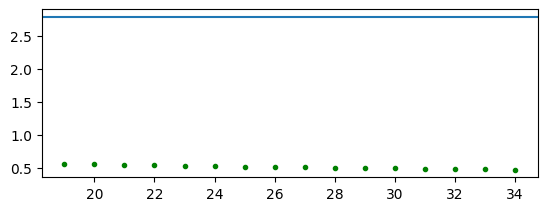

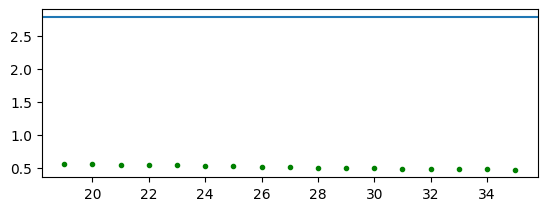

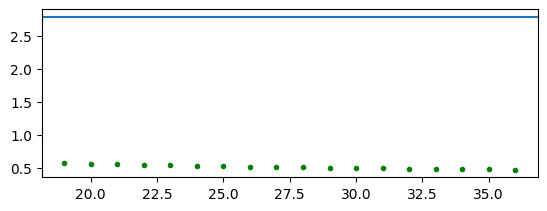

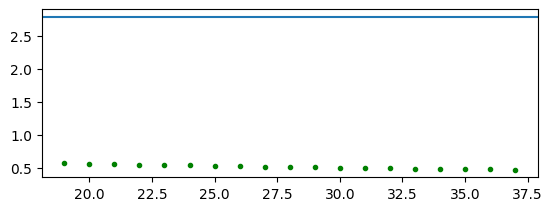

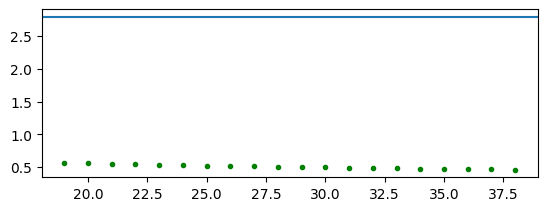

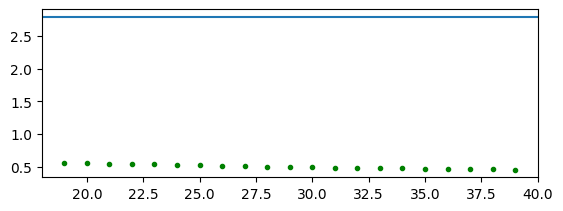

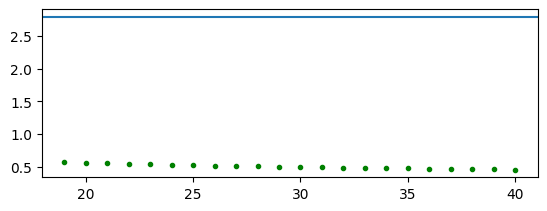

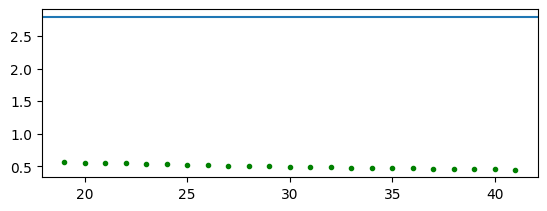

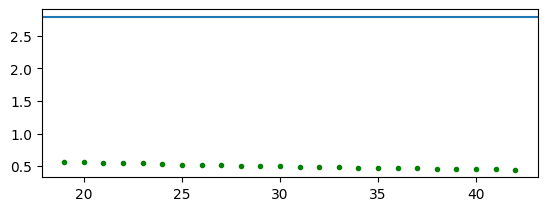

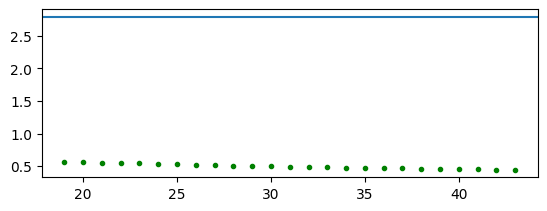

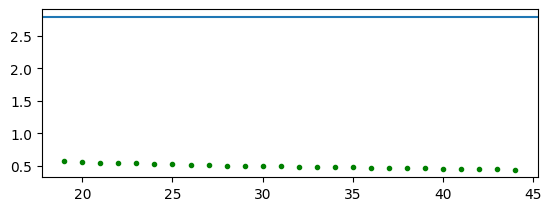

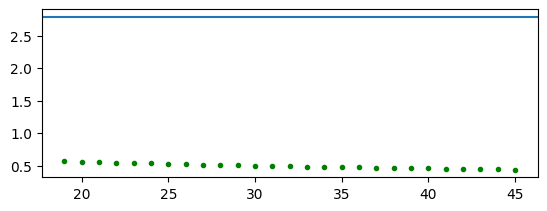

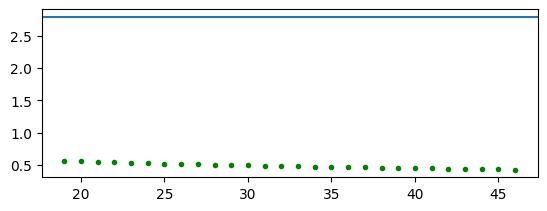

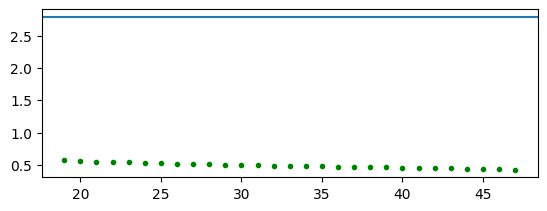

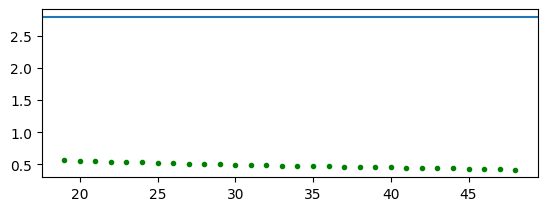

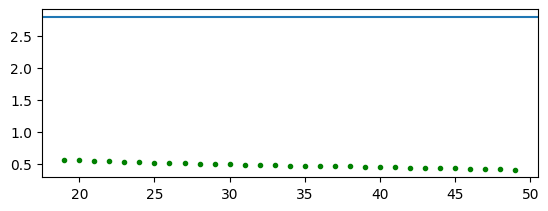

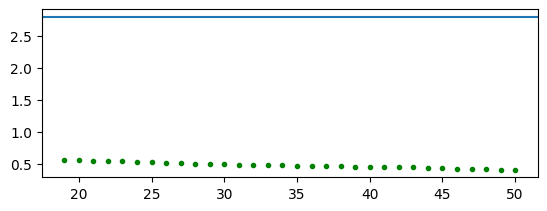

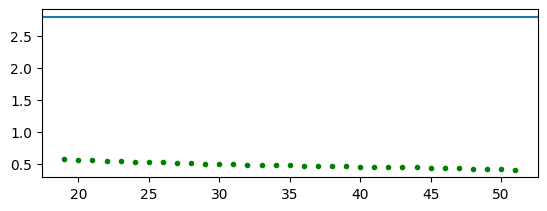

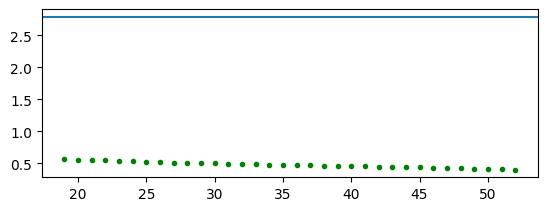

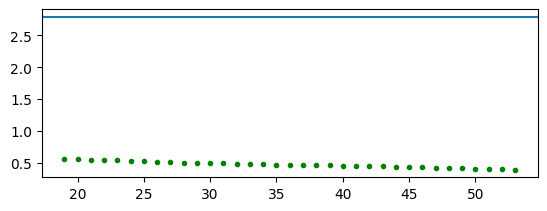

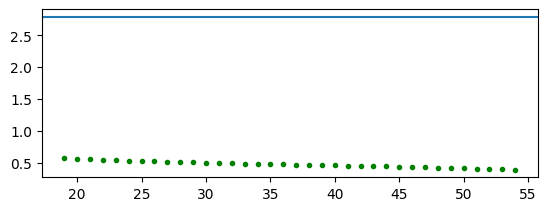

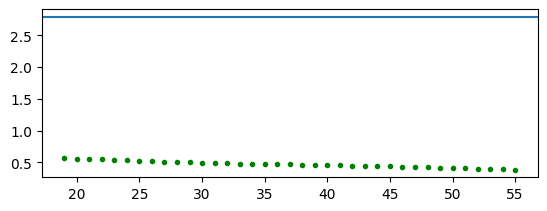

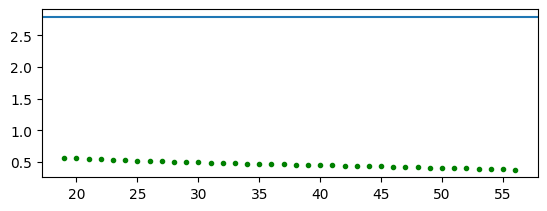

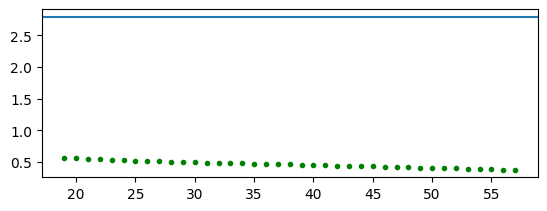

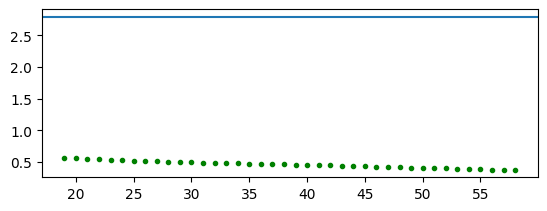

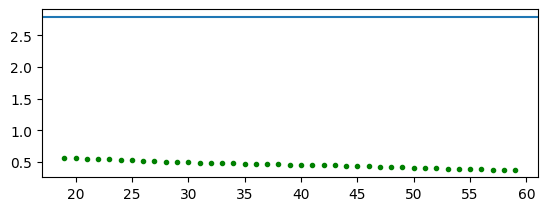

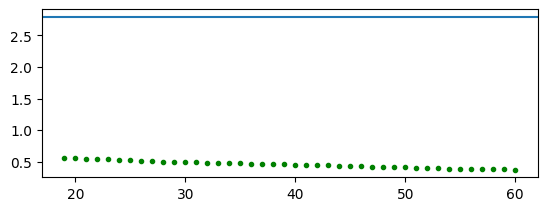

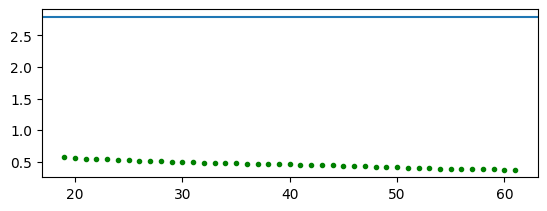

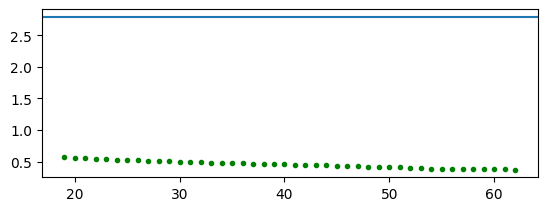

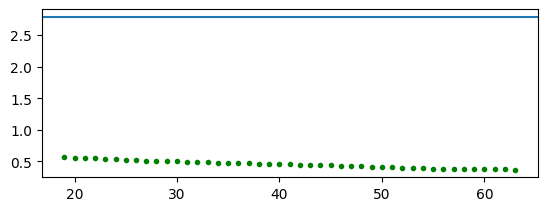

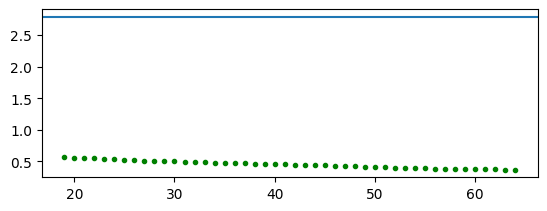

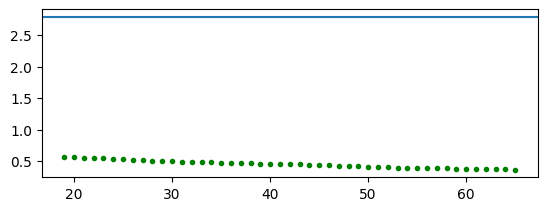

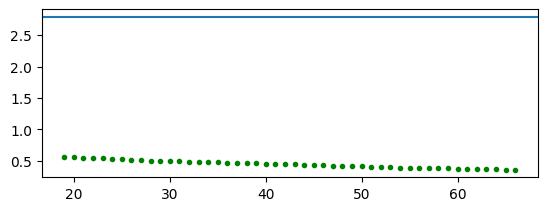

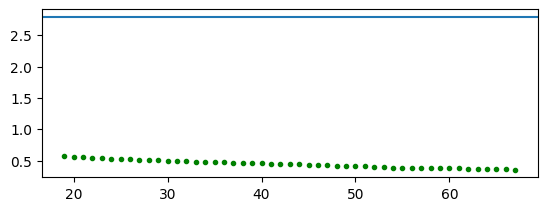

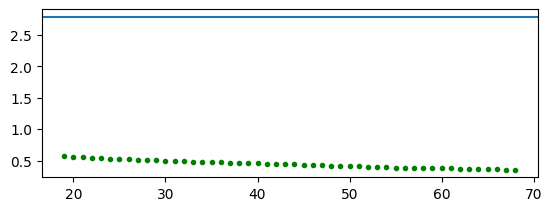

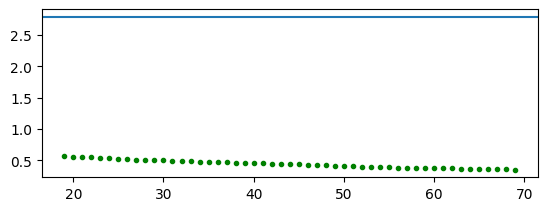

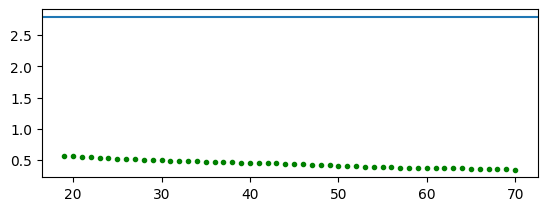

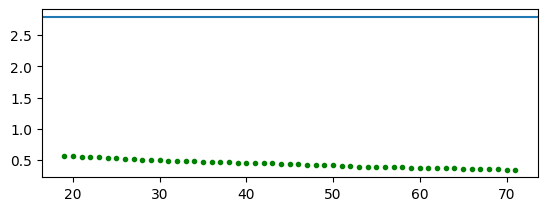

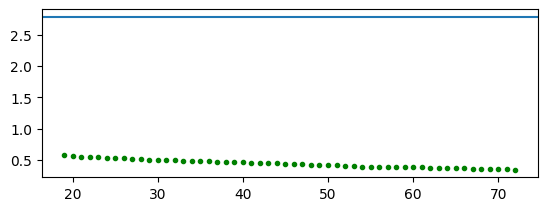

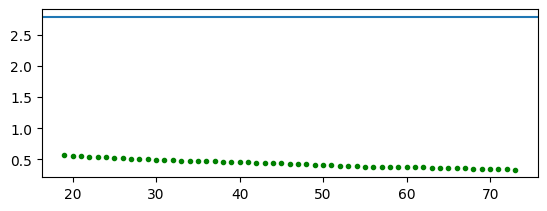

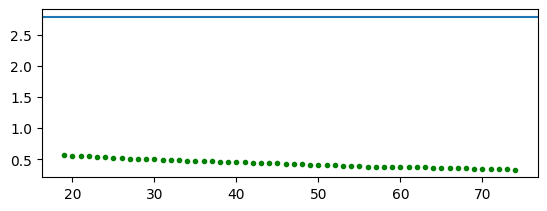

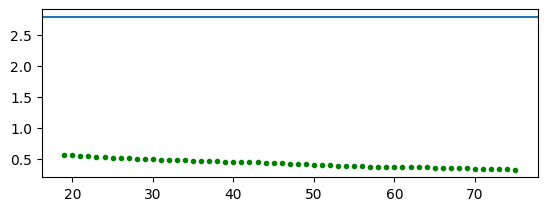

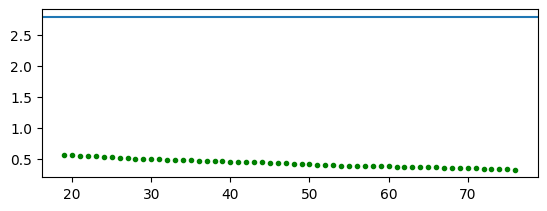

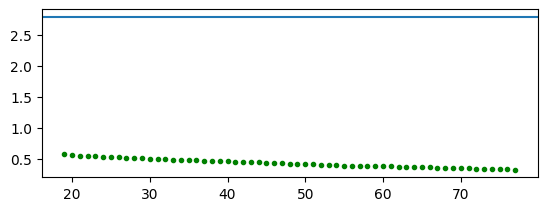

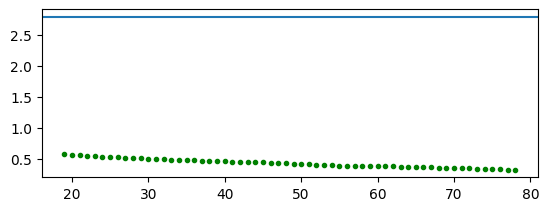

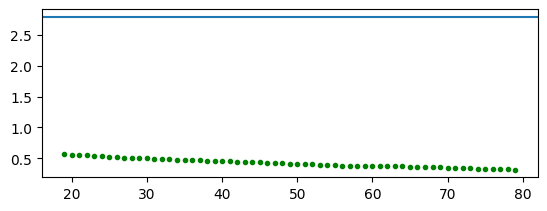

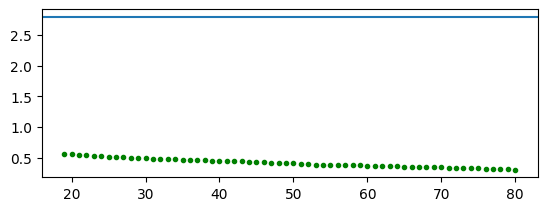

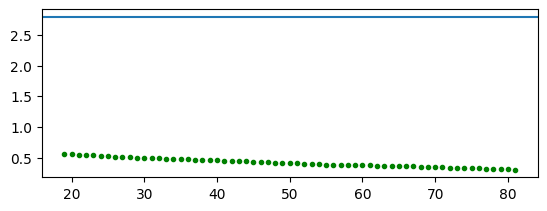

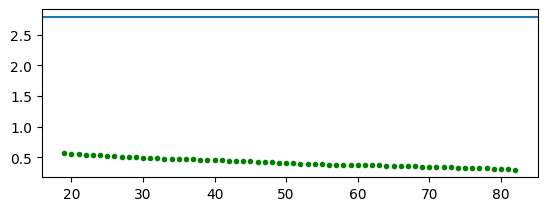

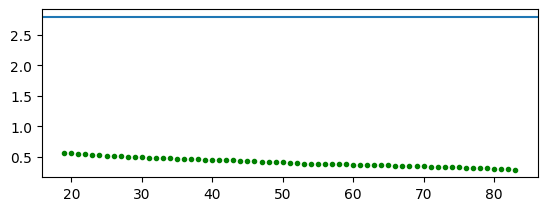

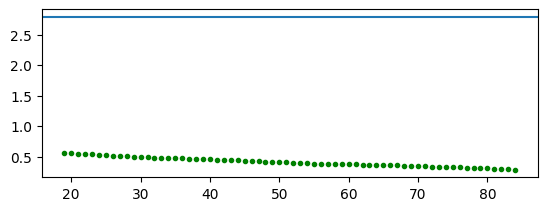

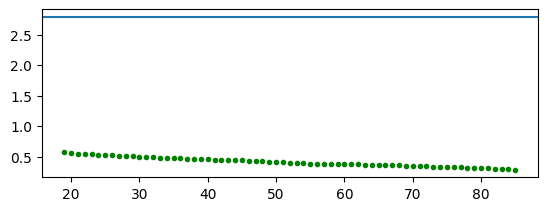

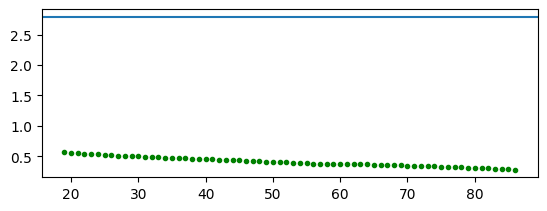

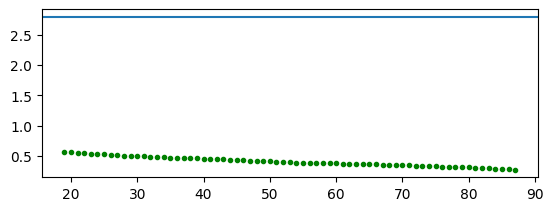

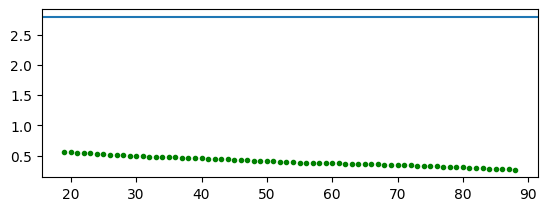

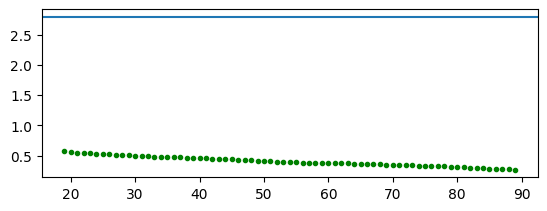

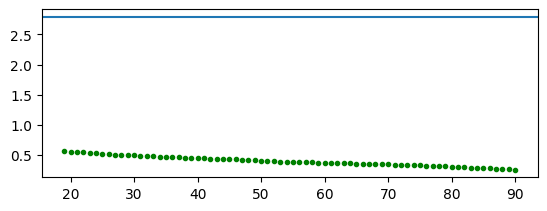

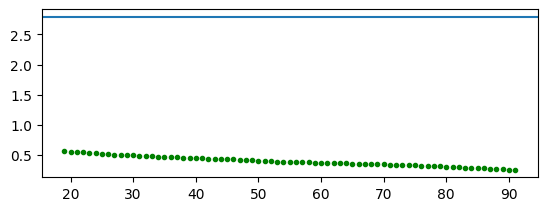

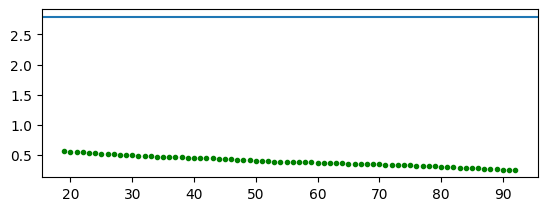

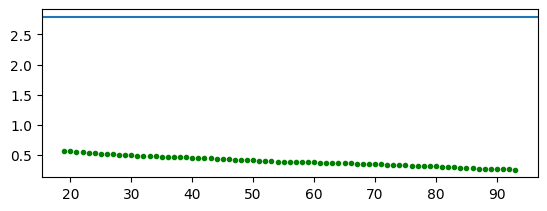

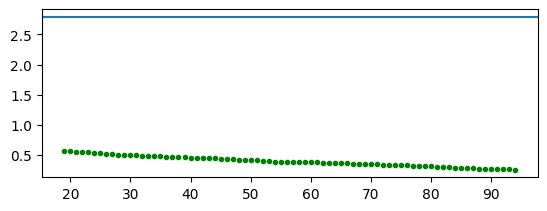

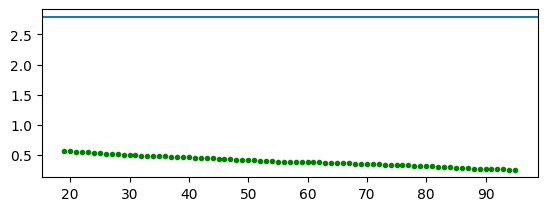

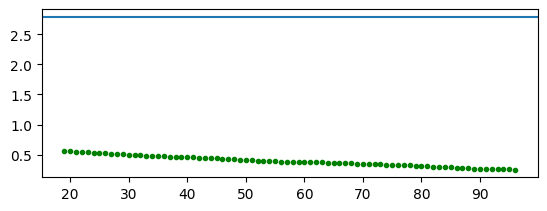

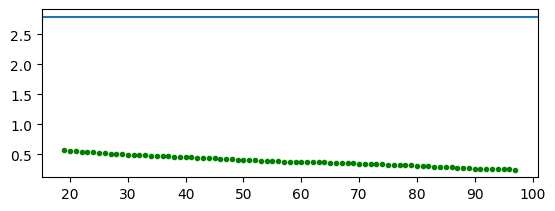

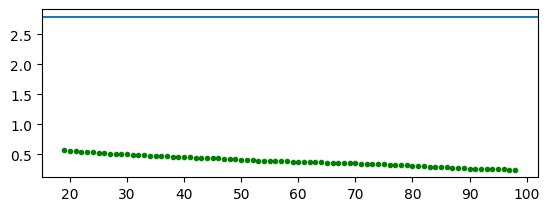

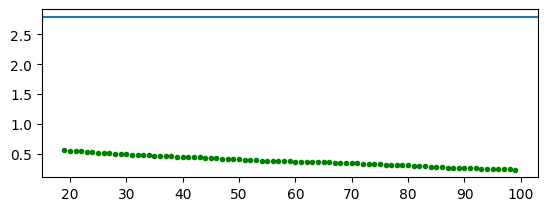

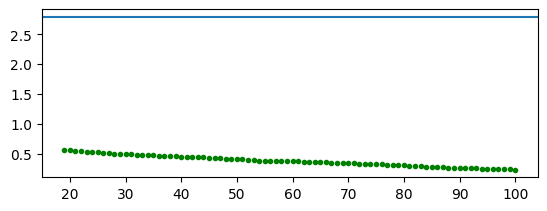

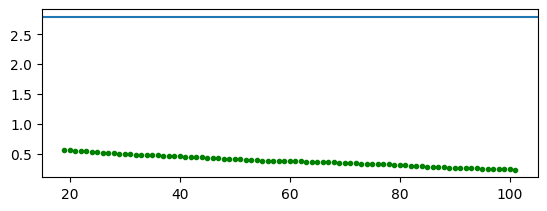

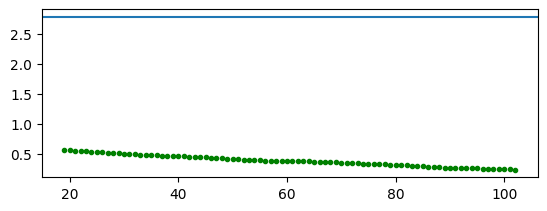

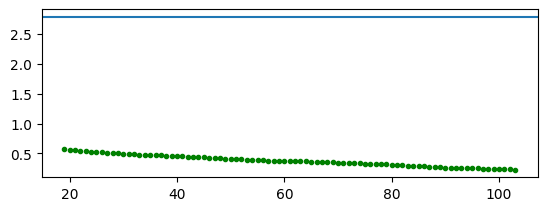

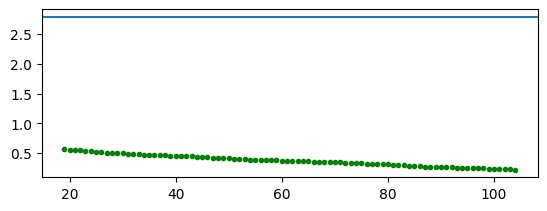

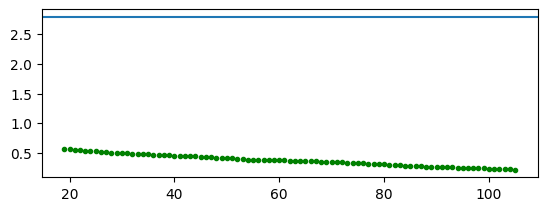

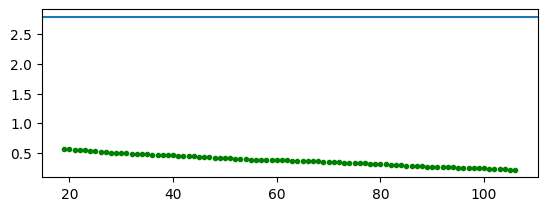

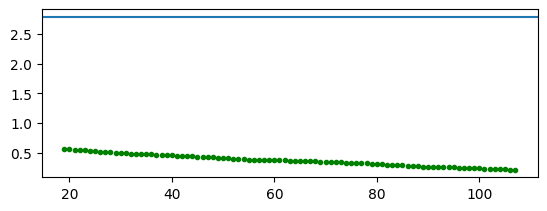

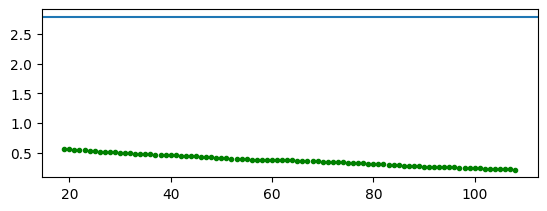

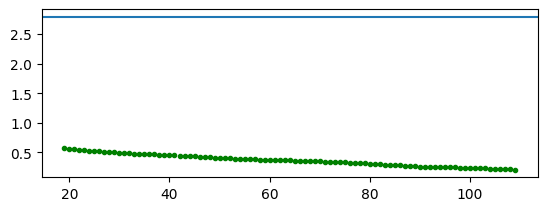

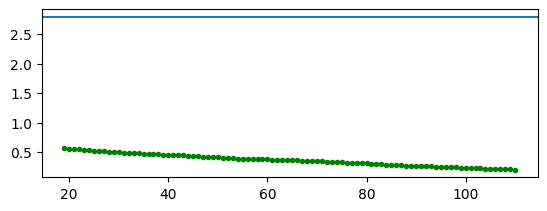

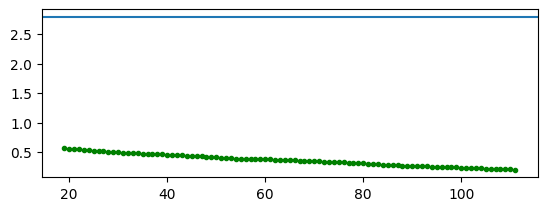

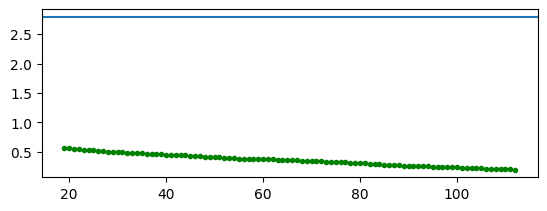

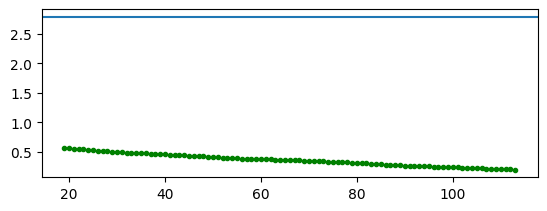

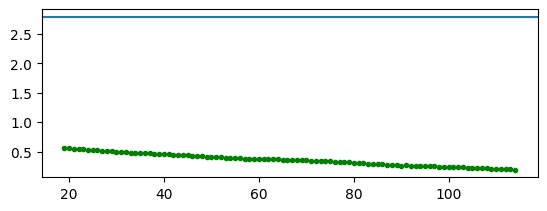

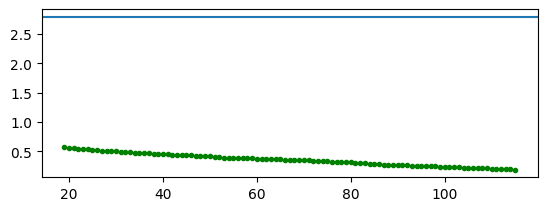

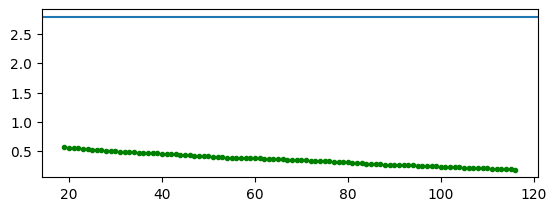

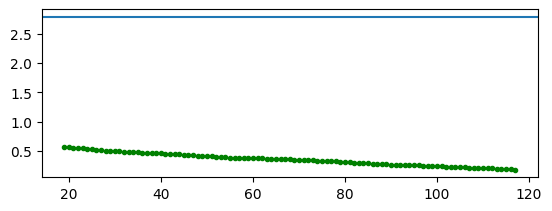

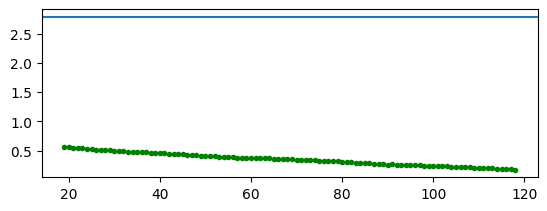

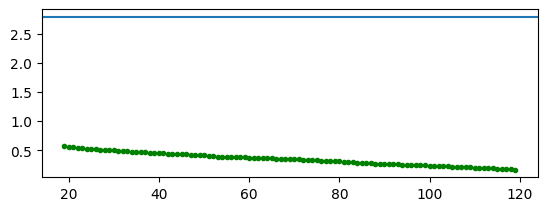

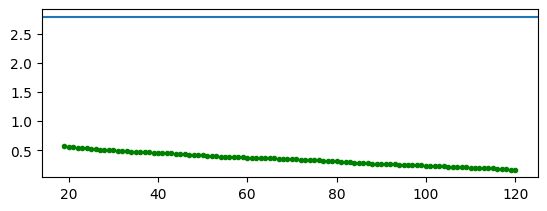

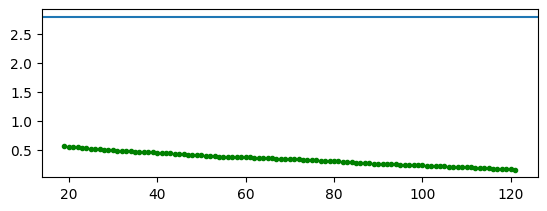

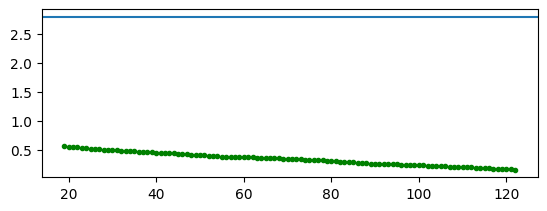

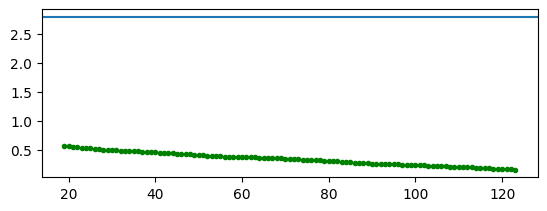

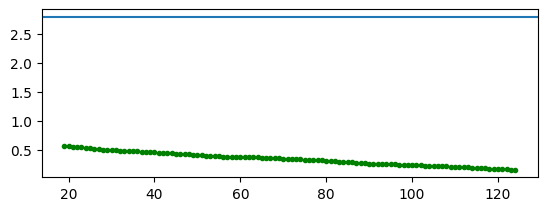

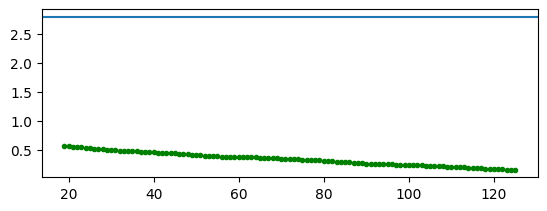

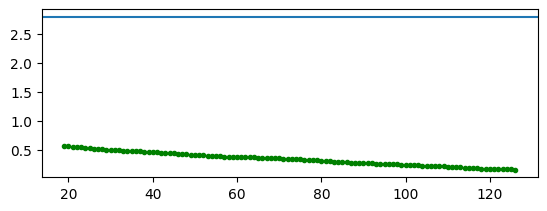

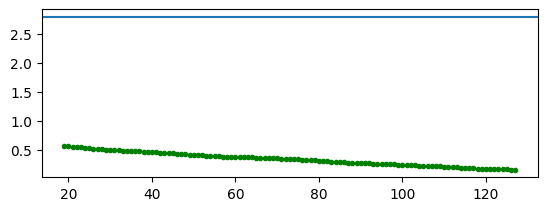

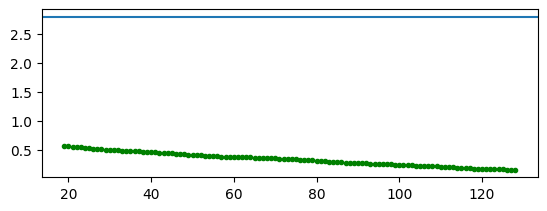

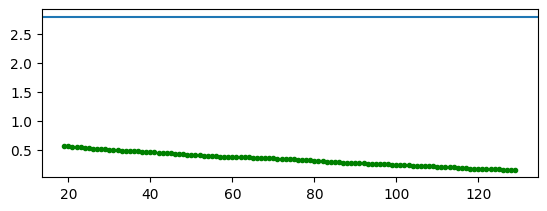

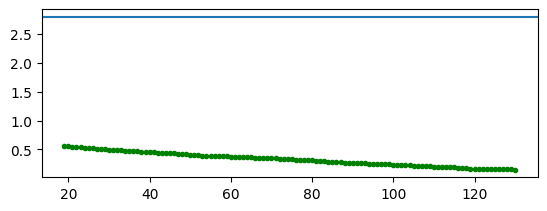

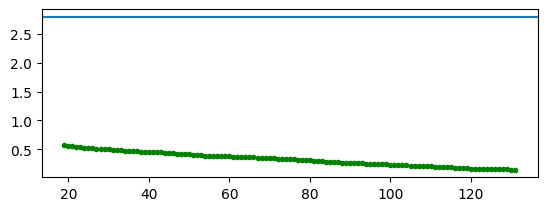

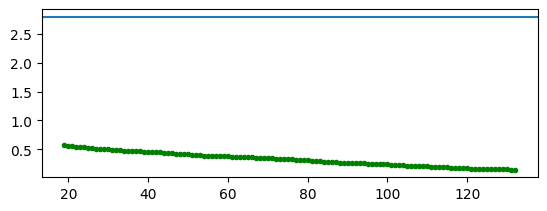

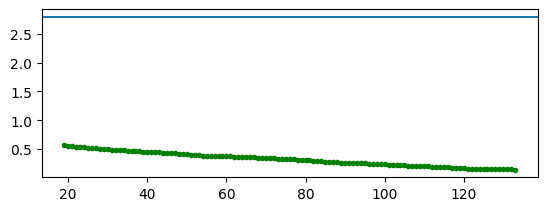

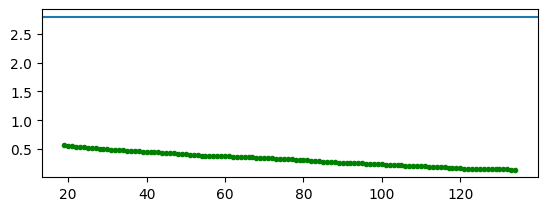

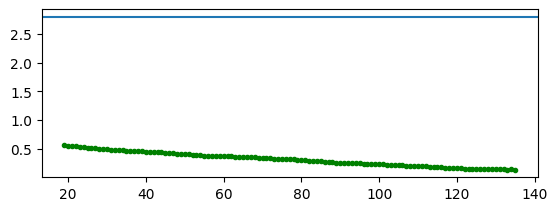

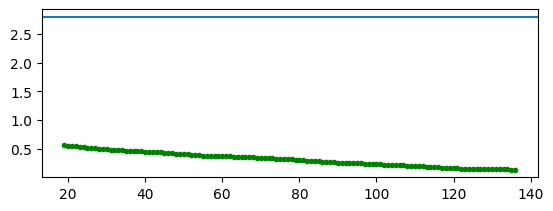

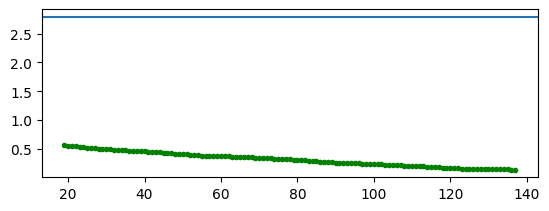

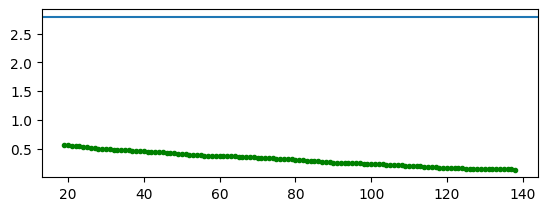

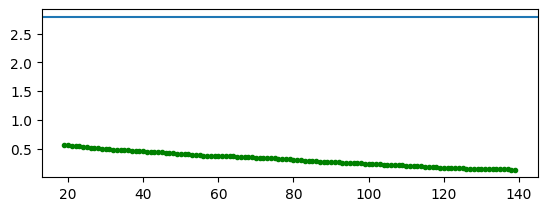

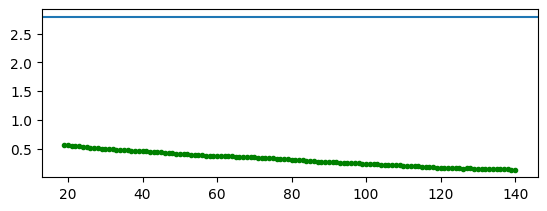

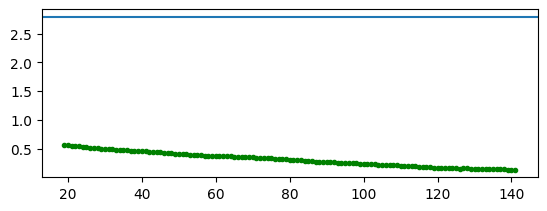

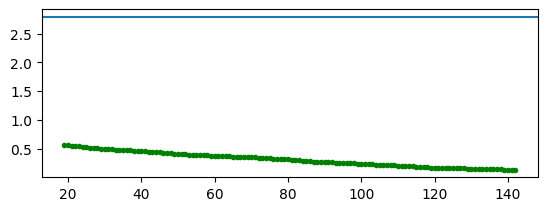

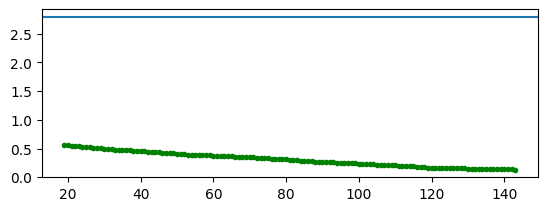

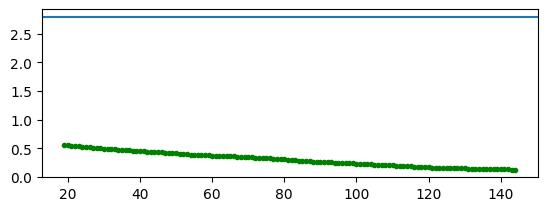

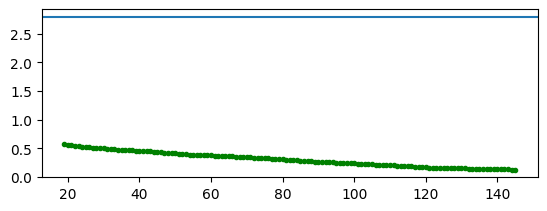

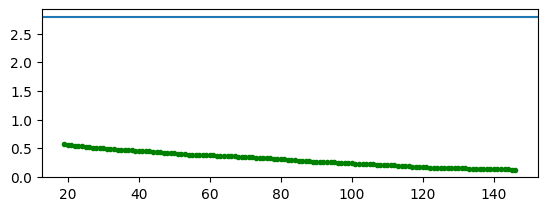

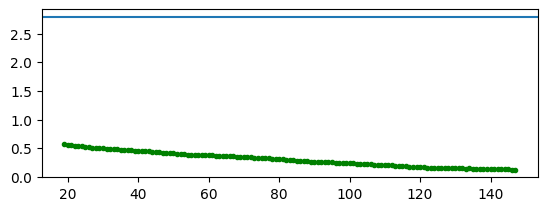

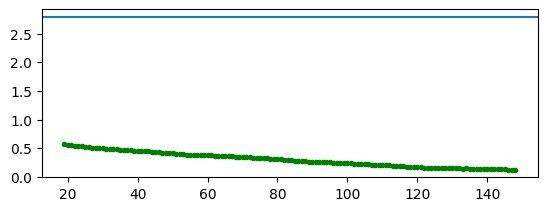

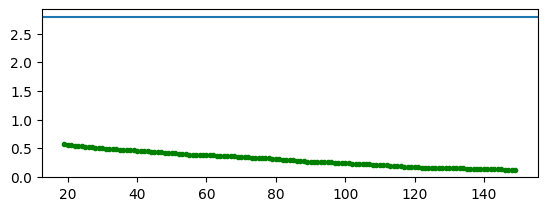

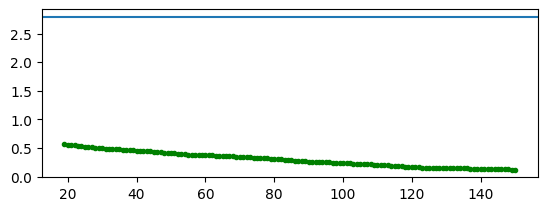

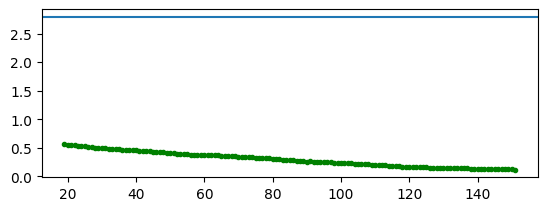

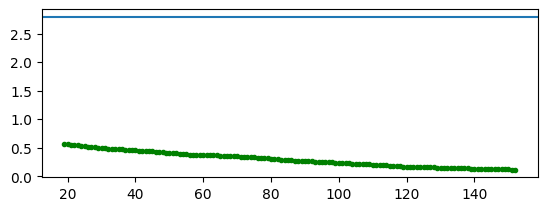

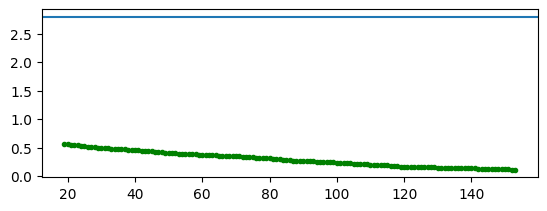

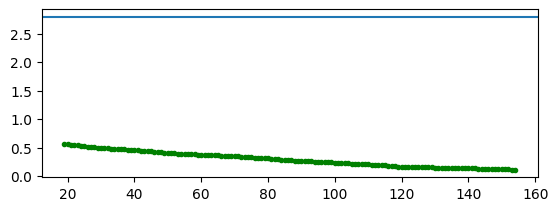

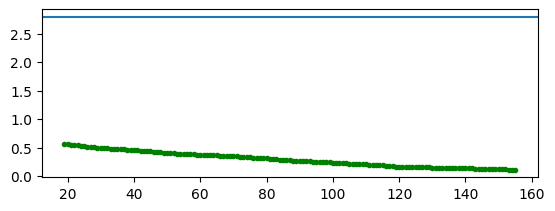

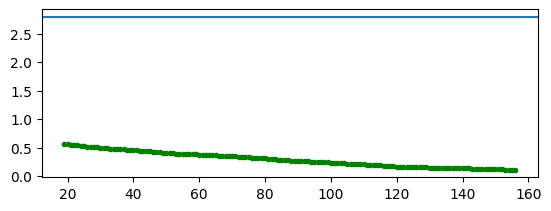

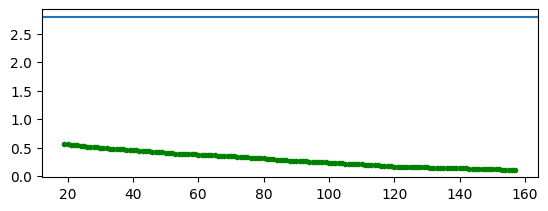

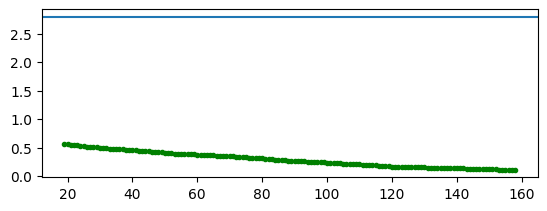

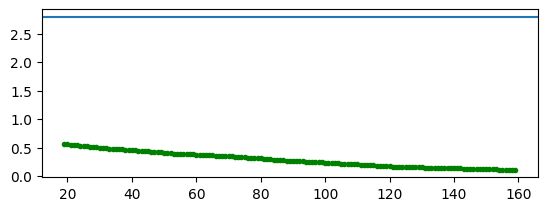

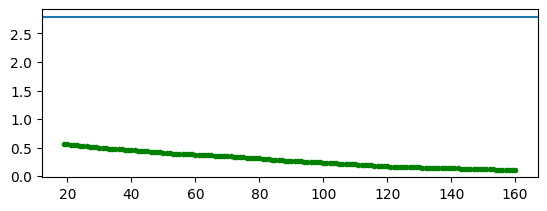

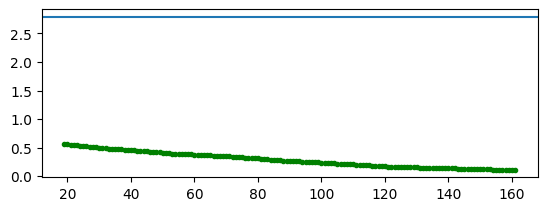

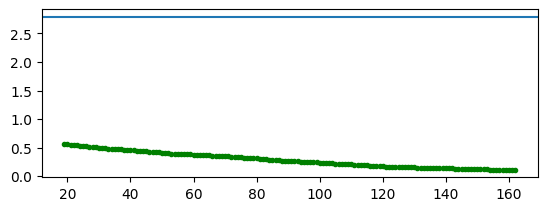

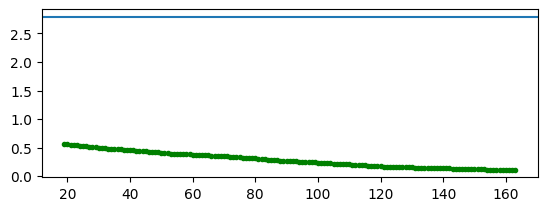

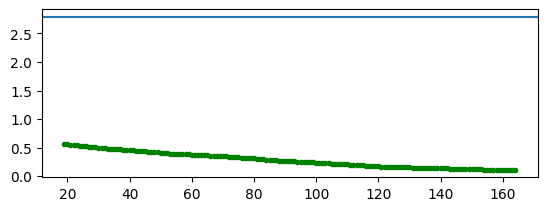

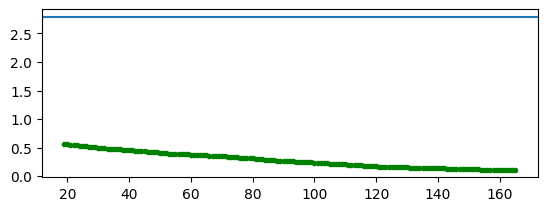

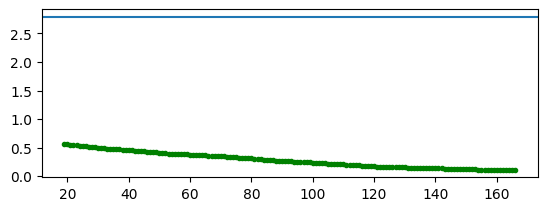

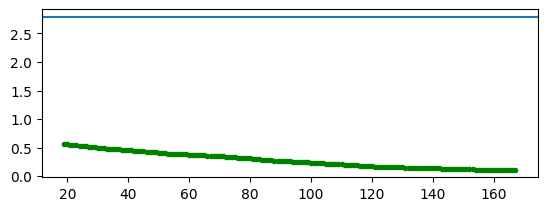

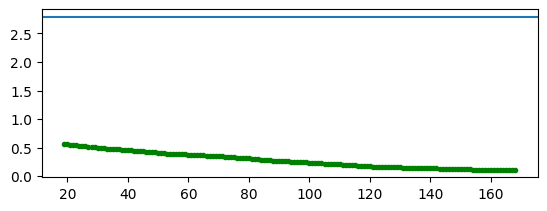

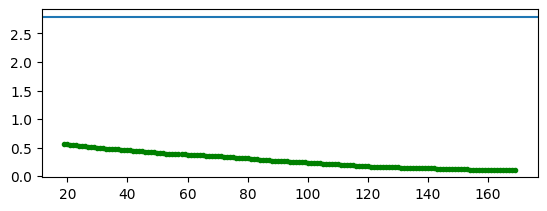

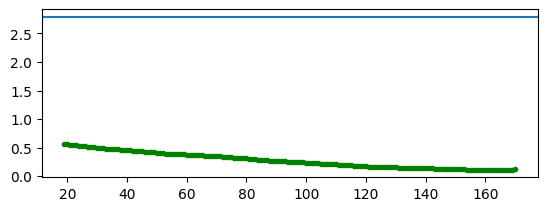

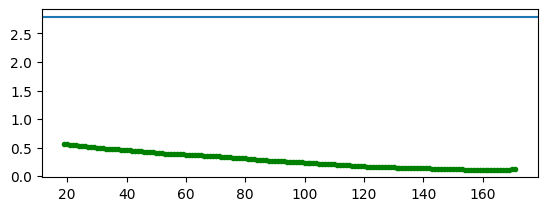

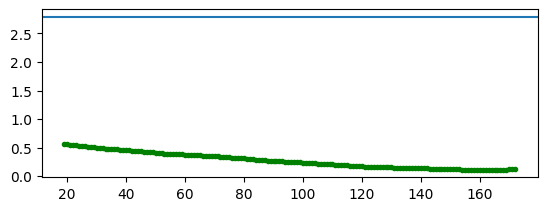

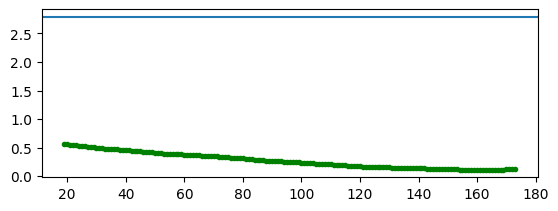

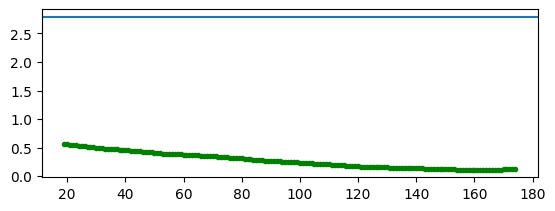

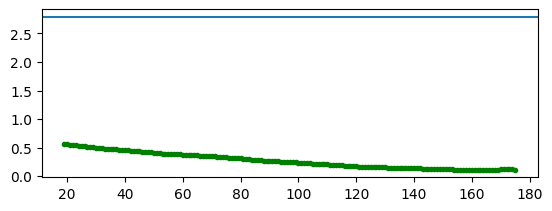

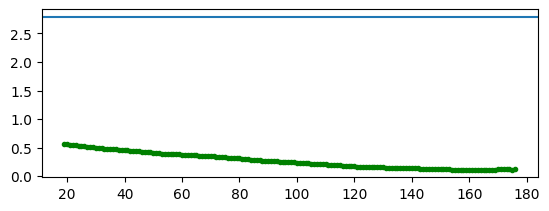

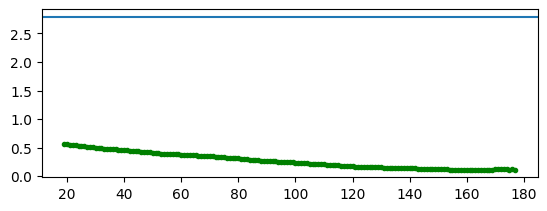

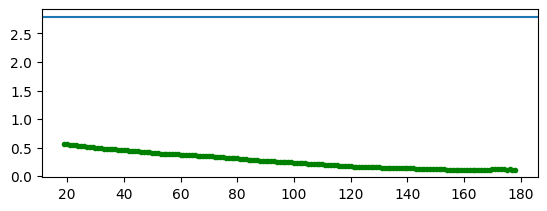

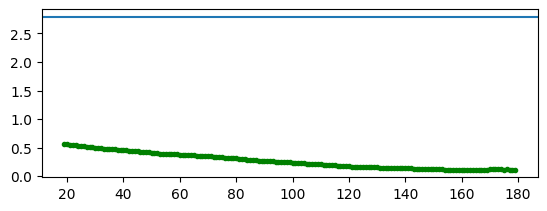

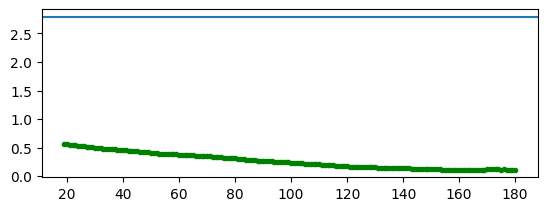

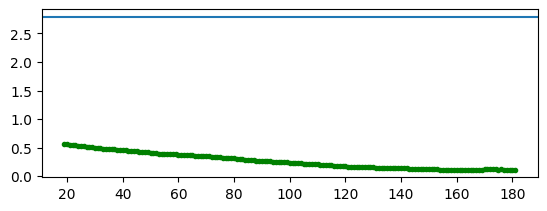

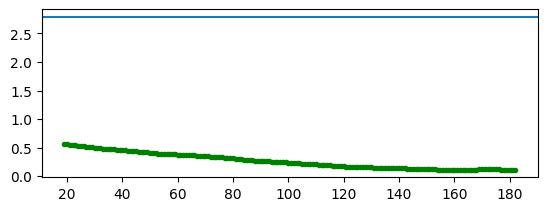

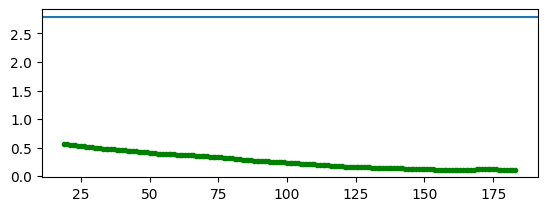

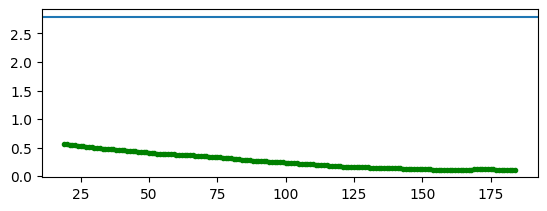

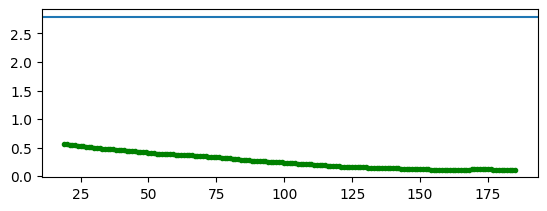

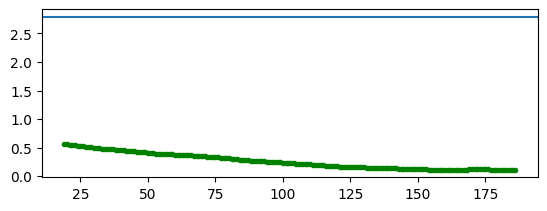

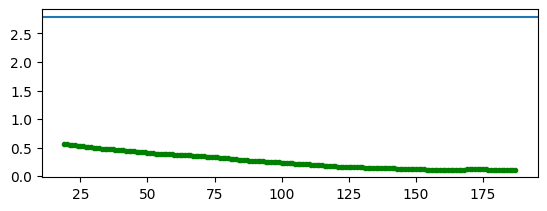

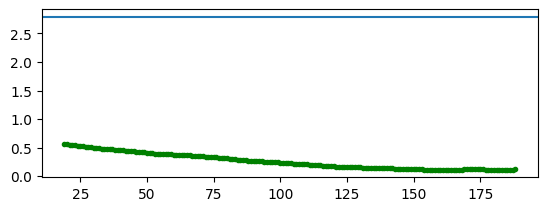

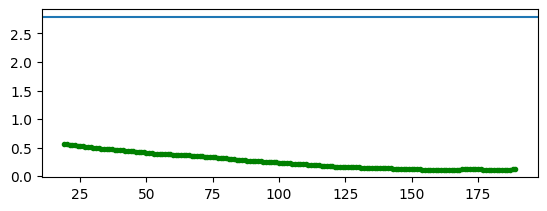

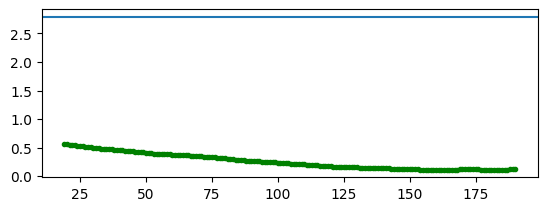

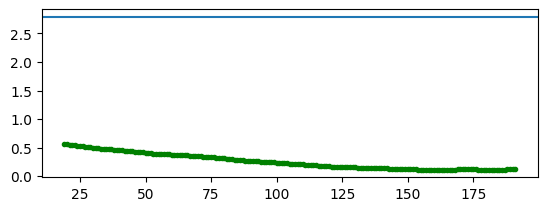

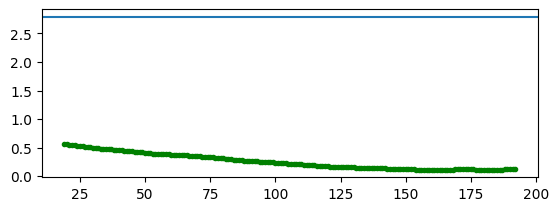

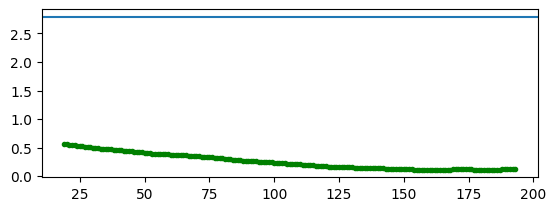

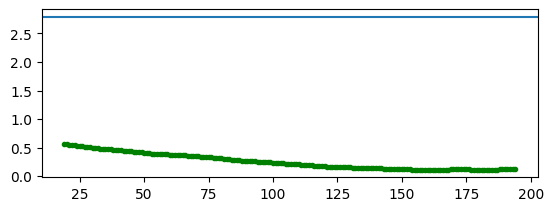

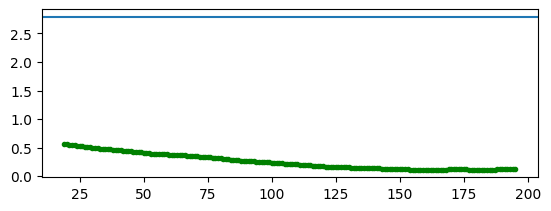

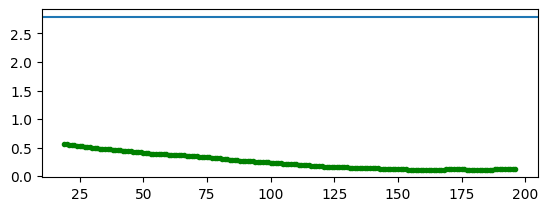

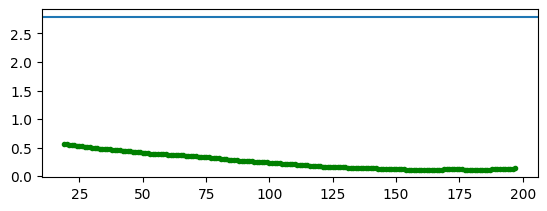

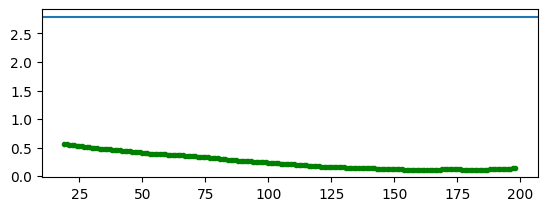

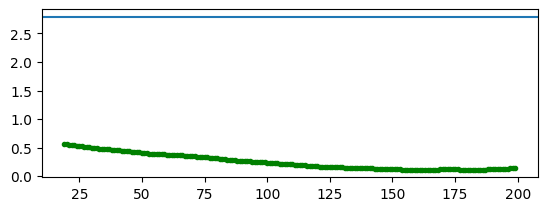

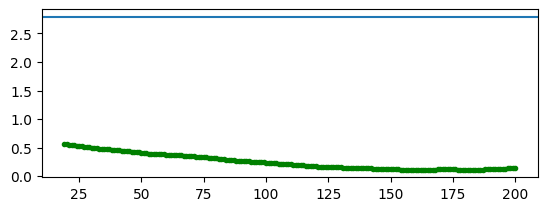

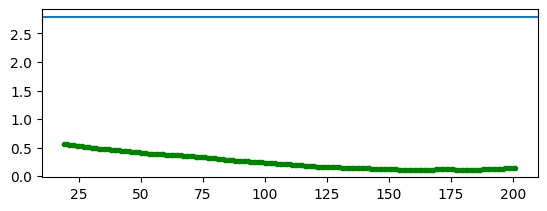

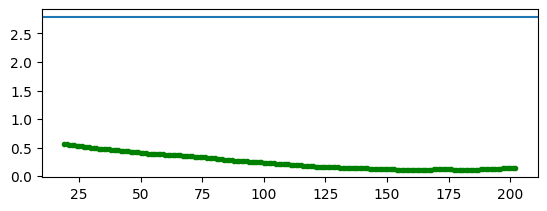

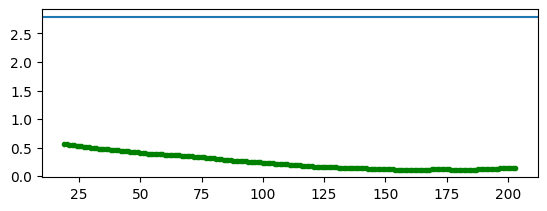

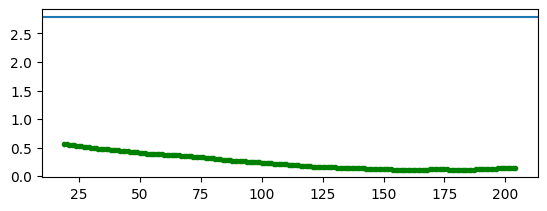

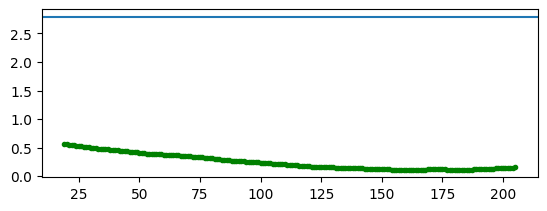

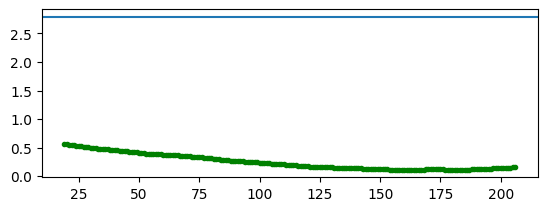

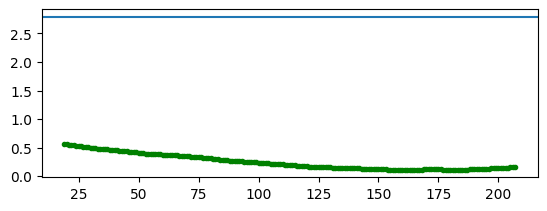

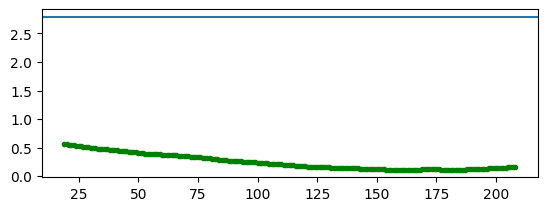

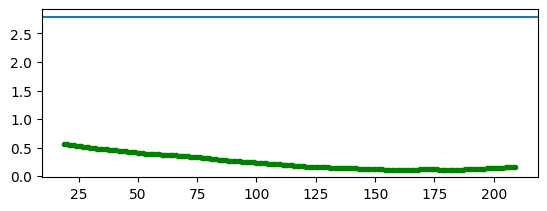

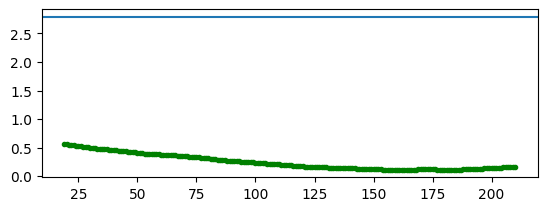

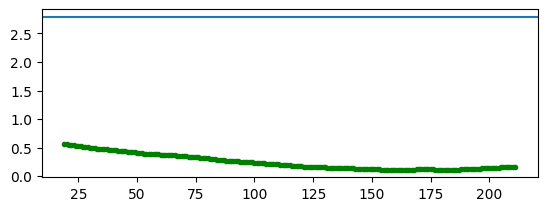

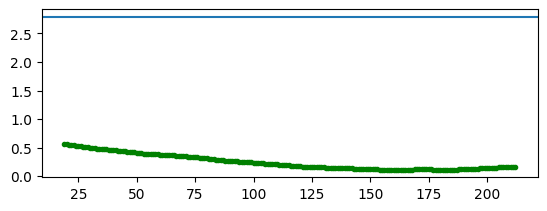

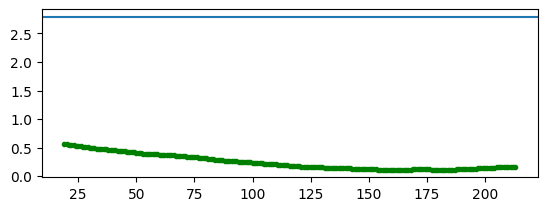

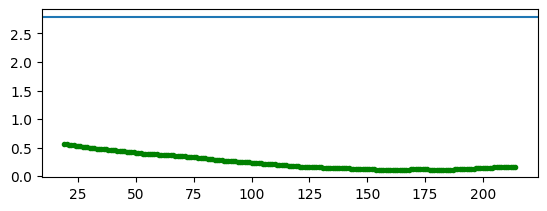

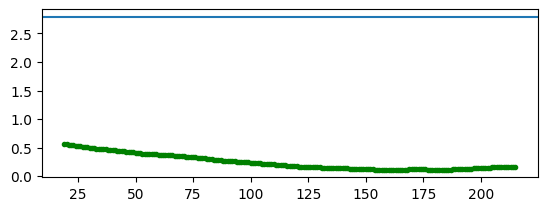

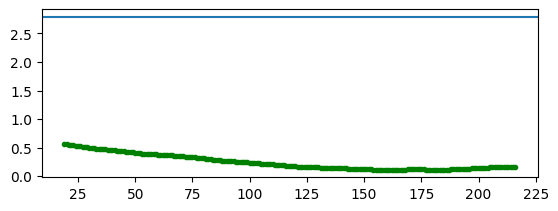

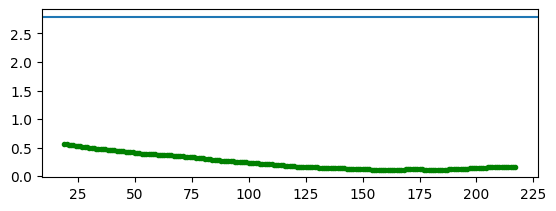

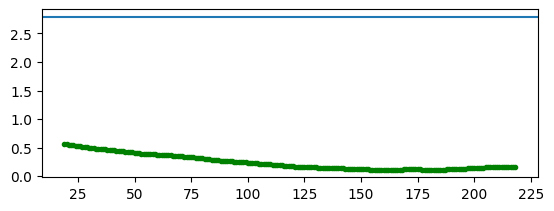

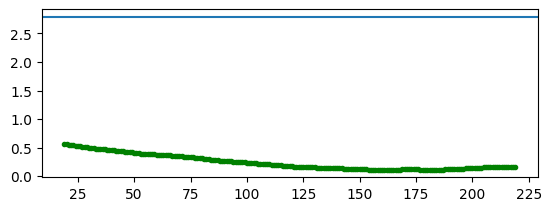

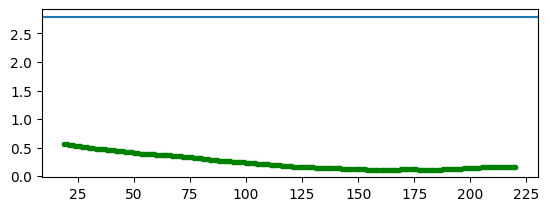

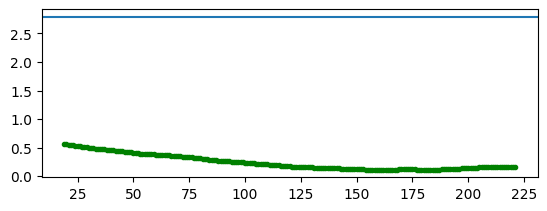

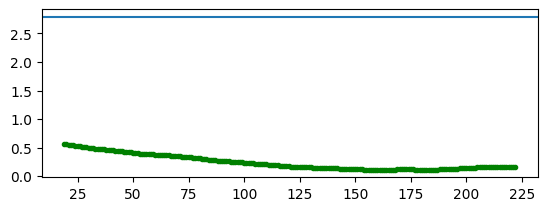

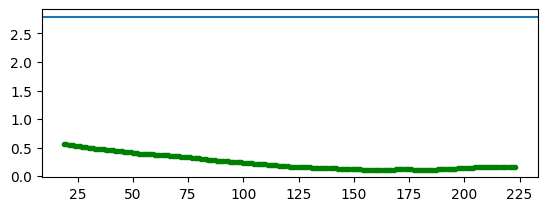

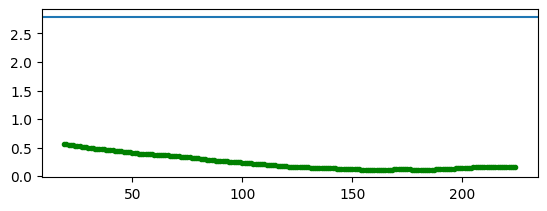

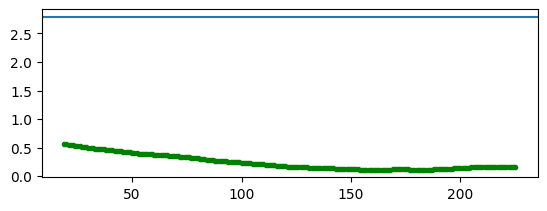

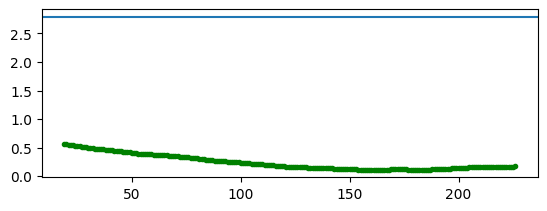

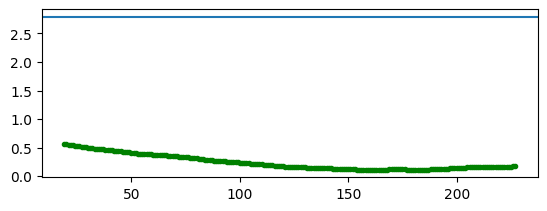

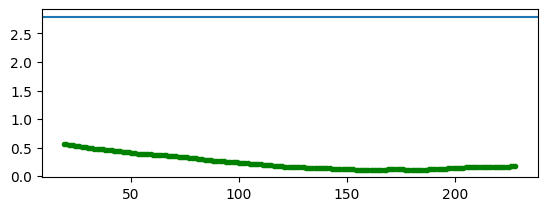

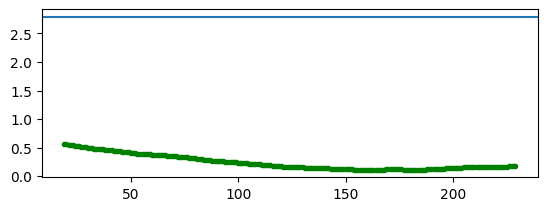

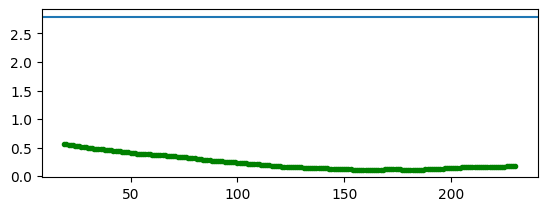

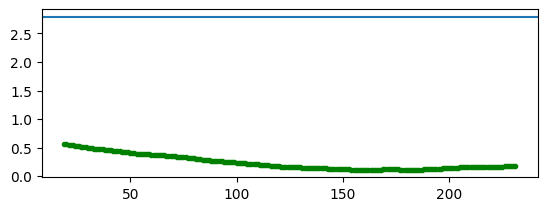

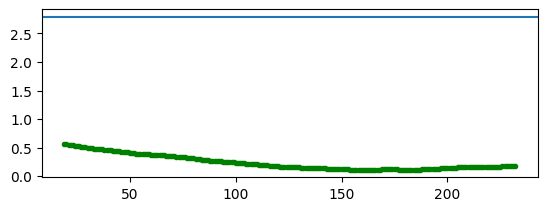

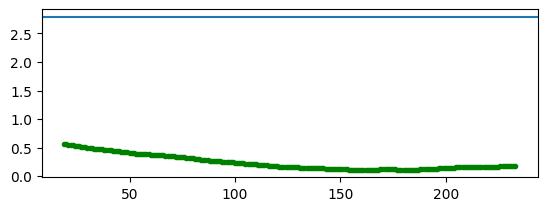

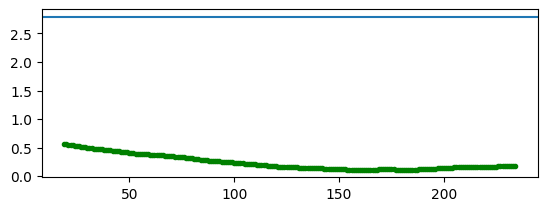

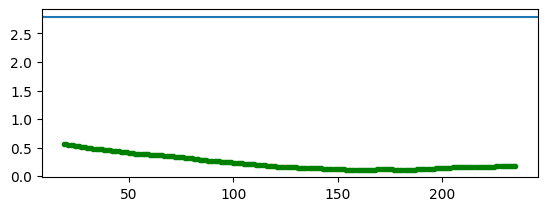

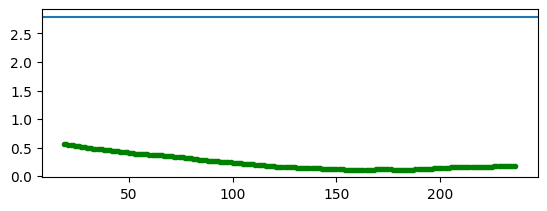

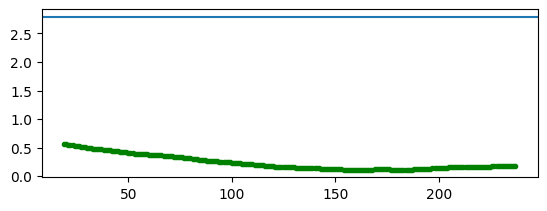

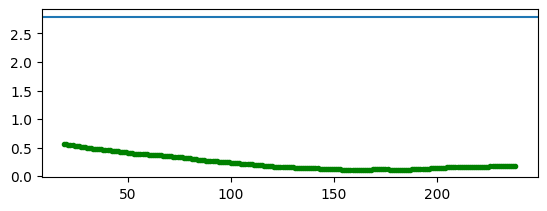

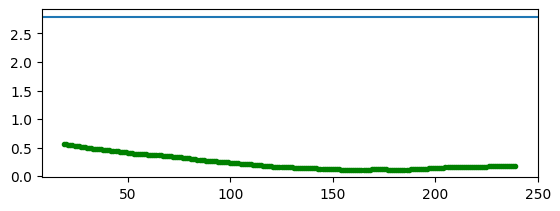

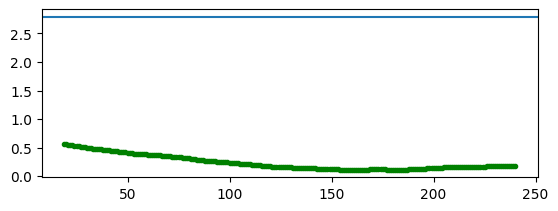

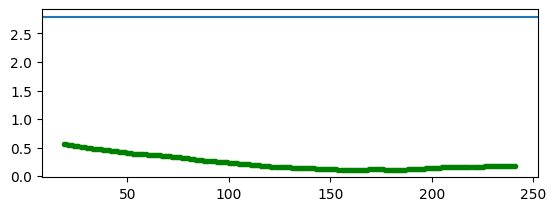

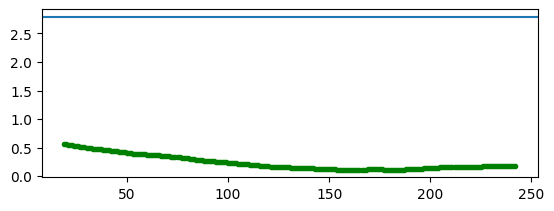

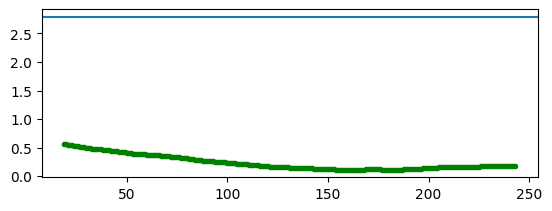

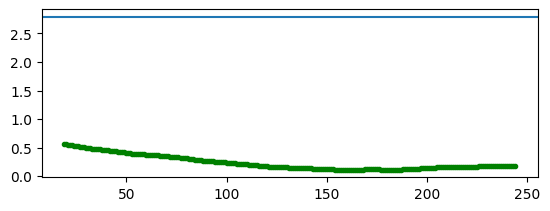

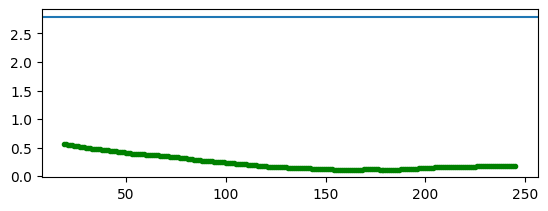

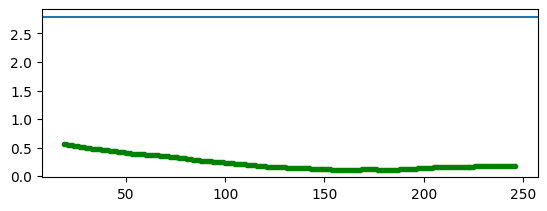

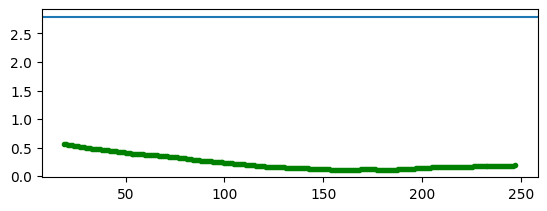

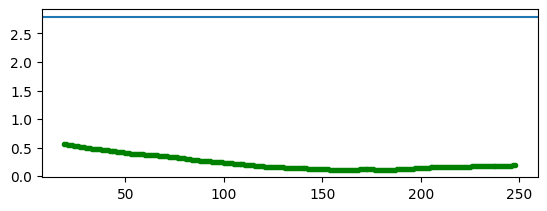

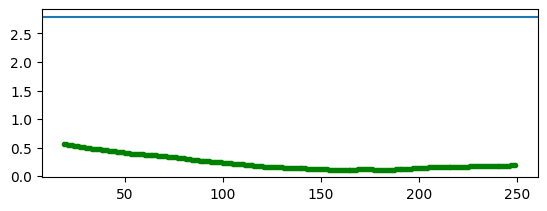

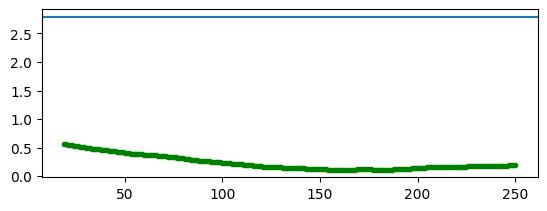

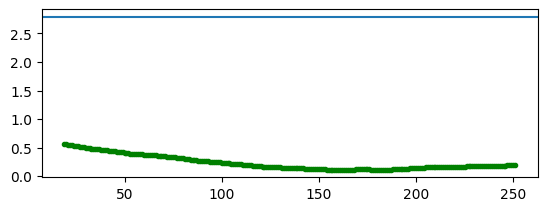

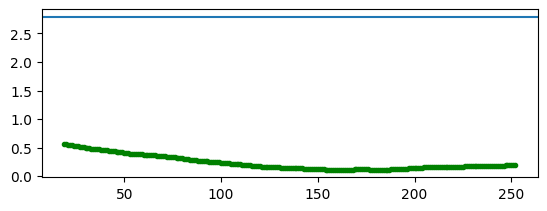

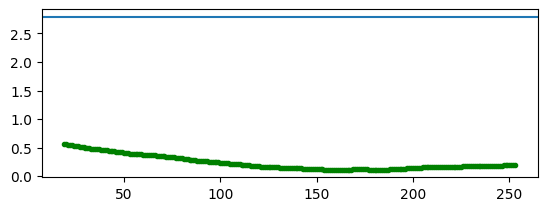

In [89]:
test_file = pickle.load(open(f'./ST4000DM000/{test_list[8]}.pkl', 'rb'))
real_y = test_file[col[-1]]
test_db = test_file[col[:-1]]
# scaled_db = scaler_zip[f'{test_list[1]}']['120'].transform(test_db)
# scaled_db = scaler_zip['120'].transform(test_db)
# scaler = StandardScaler()

threshold = 2.79082426643083

db_list = []
db = deque(maxlen=20)
dy_list = []
time = []

for i in range(len(test_db)):
    db_list.append(test_db.iloc[i])
    db.append(scaler.transform([test_db.iloc[i].values])[0])
    if len(db_list) >= 20:
        # scaler = StandardScaler()
        time.append(i)
        # scaler.fit(db_list)
        # scaled_db = scaler_zip[f'{test_list[1]}']['120'].transform(db)
        # scaled_db = scaler.transform(db)
        pred_dy = diagnostic_model.predict(np.array([db]))
        mse = np.mean(np.power(flatten(np.array([db])) - flatten(pred_dy), 2), axis=1)
        dy_list.append(mse)
        
        # pred_py = prediction_model.predict(np.array([db]))
        # py_list.append(pred_py[0])
        # yy.append(real_y[i])
        
        plt.subplot(2, 1, 1) 
        plt.plot(time, dy_list, 'g.')
        plt.axhline(threshold)
        # plt.axvline(133)
        
        # plt.subplot(2, 1, 2)
        # plt.plot(time, py_list, 'r.')
        # plt.plot(time, yy, 'b.')
        # plt.axvline(133)
        # plt.axvline(153)
        
        # plt.show()
        plt.pause(0.01)

In [58]:
test_file = pickle.load(open(f'./ST4000DM000/{test_list[8]}.pkl', 'rb'))
real_y = test_file[col[-1]]
test_db = test_file[col[:-1]]
scaled_db = scaler.transform(test_db)

threshold = 2.79082426643083

db = deque(maxlen=20)
db_temp = deque(maxlen=5)
time = []
yy = []
dy_list, py_list = [], []
for i in range(len(scaled_db)):
    db.append(scaled_db[i])
    db_temp.append(scaled_db[i])
    if len(db_temp) == 5:
        if len(db) == 20:
            time.append(i)
            
            pred_dy = diagnostic_model.predict(np.array([db_temp]))
            mse = np.mean(np.power(flatten(np.array([db_temp])) - flatten(pred_dy), 2), axis=1)
            dy_list.append(mse)
            
            pred_py = prediction_model.predict(np.array(db))
            py_list.append(pred_py[0])
            yy.append(real_y[i])
            
            plt.subplot(2, 1, 1) 
            plt.plot(time, dy_list, 'g.')
            plt.axhline(threshold)
            plt.axvline(133)
            
            plt.subplot(2, 1, 2)
            plt.plot(time, py_list, 'r.')
            plt.plot(time, yy, 'b.')
            plt.axvline(133)
            plt.axvline(153)
            
            plt.show()

c:\Program Files\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: in user code:

    File "c:\Program Files\Python39\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "c:\Program Files\Python39\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Program Files\Python39\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Program Files\Python39\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "c:\Program Files\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Program Files\Python39\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_10" is incompatible with the layer: expected shape=(None, 20, 5), found shape=(None, 5, 5)
